In [ ]:
!pip install nltk
!pip install sastrawi

## Import library

In [ ]:
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Read dataset

In [ ]:
df = pd.read_csv('/content/most_relevant_reviews_destination_palembang.csv')
df.head()

,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,url_user,place
0,ChdDSUhNMG9nS0VJQ0FnSUNsOE91Ny1BRRAB,Bagus sih tempat nya tapi kesel sama tukang pa...,3 weeks ago,2023-12-09 15:16:36,3,MR DENDI,119,https://www.google.com/maps/contrib/1034562667...,benteng kuto besak
1,ChZDSUhNMG9nS0VJQ0FnSURscllqZFlBEAE,Benteng kuto Besak. Benteng sejarah perjuangan...,6 days ago,2023-12-09 15:16:36,5,Sy Firdausy,176,https://www.google.com/maps/contrib/1169888705...,benteng kuto besak
2,ChdDSUhNMG9nS0VJQ0FnSUNwNXFIZzVRRRAB,"Palembang terkenal wisata kuliner, bukan wisat...",4 months ago,2023-12-09 15:16:36,4,Deas Dewi,39,https://www.google.com/maps/contrib/1075167764...,benteng kuto besak
3,ChdDSUhNMG9nS0VJQ0FnSUM1dHFhbTRBRRAB,"Tamasya bersama keluarga sangat cocok sekali, ...",a month ago,2023-12-09 15:16:36,5,Mase Production,144,https://www.google.com/maps/contrib/1110347091...,benteng kuto besak
4,ChdDSUhNMG9nS0VJQ0FnSURaaDl1TGl3RRAB,Tempatnya bagus bila ingin melihat keindahan j...,2 months ago,2023-12-09 15:16:36,5,Dedi Setiawan,93,https://www.google.com/maps/contrib/1092551377...,benteng kuto besak


## Data cleaning

### Clear null value

In [ ]:
df['place'].value_counts()

pulau kemaro                101
benteng kuto besak          100
warung terapung             100
riverside restaurant        100
sentral kampung pempek      100
taman purbakala             100
museum monpera              100
museum sultan mahmud II     100
jembatan ampera             100
wisata alam punti kayu      100
taman kambang iwak besak    100
bird park jaka baring       100
jaka baring sport city      100
palembang indah mall        100
sungai musi                  99
Name: place, dtype: int64

In [ ]:
df.dropna(subset=['caption'], inplace=True)

In [ ]:
df['place'].value_counts()

pulau kemaro                101
benteng kuto besak          100
riverside restaurant        100
sentral kampung pempek      100
taman purbakala             100
museum monpera              100
museum sultan mahmud II     100
wisata alam punti kayu      100
taman kambang iwak besak    100
bird park jaka baring       100
jaka baring sport city      100
palembang indah mall        100
jembatan ampera              76
sungai musi                  59
warung terapung              44
Name: place, dtype: int64

### Clear emoji and symbol

In [ ]:
def clean_caption(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text_no_emoji = emoji_pattern.sub(r'', text)

    # case folding
    text_no_emoji = text_no_emoji.lower()

    # remove whitespace
    text_no_emoji = text_no_emoji.strip()

    # Remove other symbols and non-alphanumeric characters
    text_cleaned = re.sub(r'[^a-zA-Z0-9\s]', '', text_no_emoji)

    return text_cleaned

In [ ]:
# Apply the cleaning function to the 'caption' column
df['caption'] = df['caption'].apply(clean_caption)

In [ ]:
df['caption'][0]

'bagus sih tempat nya tapi kesel sama tukang parkir nya  pengamen jadi buat kalian yang ajak keluarga dari luar kota palembang tetap hati ya jaga barang bawak an anda semua'

### Clear stopwords

In [ ]:
# Read the stopwords from the file
stopwords_file = '/content/stopwords-id.txt'
with open(stopwords_file, 'r') as file:
    stopwords = file.read().splitlines()

In [ ]:
# Function to remove stopwords from a text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(filtered_words)

In [ ]:
# Apply the remove_stopwords function to the 'caption' column
df['caption'] = df['caption'].apply(remove_stopwords)

In [ ]:
df['caption'][0]

'bagus sih nya kesel tukang parkir nya pengamen ajak keluarga kota palembang hati ya jaga barang bawak an'

### Stemming

In [ ]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming_text(text):
  stemmed = stemmer.stem(text)
  return stemmed

In [ ]:
# Apply the remove_stopwords function to the 'caption' column
df['caption'] = df['caption'].apply(stemming_text)

In [ ]:
df['caption'][2]

'palembang kenal wisata kuliner wisata alam icon kota palembang salah nya bkb monpera ampera dar saran poto duk amen nya risih poto abai tawar thanks'

### Save the dataframe because stemming took long time

In [ ]:
df.to_csv('reviews_cleaned.csv')

## Read new stemming data

In [ ]:
df = pd.read_csv('/content/reviews_cleaned.csv')

drop null value

In [ ]:
df = df.dropna(subset=['caption'])

## Encoding label

In [ ]:
# Sample labels
labels_list = ["benteng kuto besak","pulau kemaro", "sungai musi",
          "warung terapung", "riverside restaurant", "sentral kampung pempek",
          "taman purbakala", "museum monpera", "museum sultan mahmud II",
          "jembatan ampera", "wisata alam punti kayu", "taman kambang iwak besak",
          "bird park jaka baring", "jaka baring sport city", "palembang indah mall"]

# Create a dictionary to map labels to numerical indices
label_mapping = {label: index for index, label in enumerate(labels_list)}

# Print the label mapping
print(label_mapping)

{'benteng kuto besak': 0, 'pulau kemaro': 1, 'sungai musi': 2, 'warung terapung': 3, 'riverside restaurant': 4, 'sentral kampung pempek': 5, 'taman purbakala': 6, 'museum monpera': 7, 'museum sultan mahmud II': 8, 'jembatan ampera': 9, 'wisata alam punti kayu': 10, 'taman kambang iwak besak': 11, 'bird park jaka baring': 12, 'jaka baring sport city': 13, 'palembang indah mall': 14}


## Split Dataset

In [ ]:
sentences = df['caption'].values
labels = df['place'].values

In [ ]:
df['place']

0         benteng kuto besak
1         benteng kuto besak
2         benteng kuto besak
3         benteng kuto besak
4         benteng kuto besak
                ...         
1375    palembang indah mall
1376    palembang indah mall
1377    palembang indah mall
1378    palembang indah mall
1379    palembang indah mall
Name: place, Length: 1378, dtype: object

In [ ]:
# Assuming you have training_labels and validation_labels
labels_encoded = [label_mapping[label] for label in labels]


# Convert the lists to NumPy arrays if needed
labels_encoded = np.array(labels_encoded)

In [ ]:
training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(sentences, labels_encoded, train_size=0.8, shuffle=True)

In [ ]:
print(training_sentences[0])
print(training_labels[0])

salah wisata kota palembang fasilitas tawar wahana main santai outbound area kolam hunting foto mushola toilet parkir luas lapang main luas akses agam bus ojek gojek gocar taxi rekomendasi piknik keluarga teman dar lepas penat santa
10


### Tokenization

In [ ]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

### Export the Tokenizer

In [ ]:
# Save the tokenizer using pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Save the model
joblib.dump(tokenizer, "tokenizer2.pkl")

['tokenizer2.pkl']

In [ ]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Make Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(15, activation='softmax')
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Training Model

In [ ]:
history = model.fit(training_padded, training_labels, epochs=50,
          validation_data=(validation_padded, validation_labels),
          )

Epoch 1/50
35/35 [==============================] - 17s 303ms/step - loss: 2.7028 - accuracy: 0.0726 - val_loss: 2.6976 - val_accuracy: 0.0652
Epoch 2/50
35/35 [==============================] - 9s 268ms/step - loss: 2.6927 - accuracy: 0.0662 - val_loss: 2.6739 - val_accuracy: 0.0688
Epoch 3/50
35/35 [==============================] - 11s 305ms/step - loss: 2.6456 - accuracy: 0.0971 - val_loss: 2.5918 - val_accuracy: 0.0833
Epoch 4/50
35/35 [==============================] - 8s 229ms/step - loss: 2.5100 - accuracy: 0.1352 - val_loss: 2.4089 - val_accuracy: 0.1558
Epoch 5/50
35/35 [==============================] - 9s 249ms/step - loss: 2.3273 - accuracy: 0.1597 - val_loss: 2.3420 - val_accuracy: 0.1449
Epoch 6/50
35/35 [==============================] - 6s 156ms/step - loss: 2.1803 - accuracy: 0.2015 - val_loss: 2.2430 - val_accuracy: 0.2138
Epoch 7/50
35/35 [==============================] - 6s 163ms/step - loss: 2.0176 - accuracy: 0.2704 - val_loss: 2.1010 - val_accuracy: 0.2826
Epoc

### Plot result

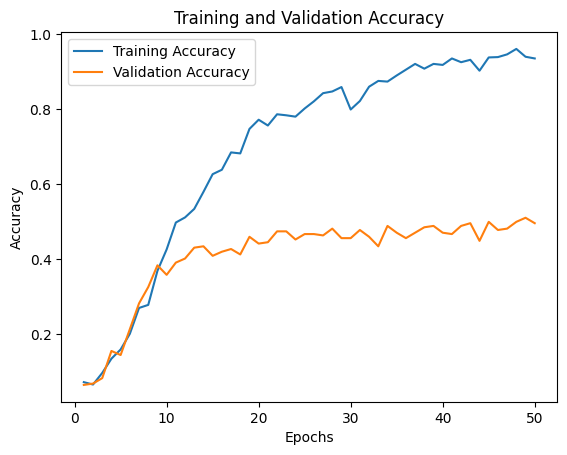

In [ ]:
# Extracting accuracy and validation accuracy from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the accuracy
plt.plot(range(1, len(accuracy) + 1), accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Save the model

In [ ]:
model.save('model_v3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
joblib.dump(model, "model_v3.pkl")

['model_v3.pkl']

## Test the model

In [ ]:
dic_label = {
    0: "benteng kuto besak",
    1: "pulau kemaro",
    2: "sungai musi",
    3: "warung terapung",
    4: "riverside restaurant",
    5: "sentral kampung pempek",
    6: "taman purbakala",
    7: "museum monpera",
    8: "museum sultan mahmud II",
    9: "jembatan ampera",
    10: "wisata alam punti kayu",
    11: "taman kambang iwak besak",
    12: "bird park jaka baring",
    13: "jaka baring sport city",
    14: "palembang indah mall",
}

In [ ]:
from tensorflow.keras.models import load_model

# Assuming you have loaded your real data into a variable called 'real_data'
real_data = ["saya ingin ke tempat wisata yang memiliki taman dan makanan yang enak dan sejuk"]

# Assuming 'tokenizer' and 'label_tokenizer' are already defined as in your code
real_data_sequences = tokenizer.texts_to_sequences(real_data)
real_data_padded = pad_sequences(real_data_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)

# Load the trained model
model = load_model('model_v2.h5')  # Replace 'your_model.h5' with the actual filename

# Make predictions
predictions = model.predict(real_data_padded)

# Get the top N predictions
top_n = 3
top_indices = np.argsort(predictions[0])[-top_n:][::-1]
top_probabilities = predictions[0][top_indices]

# Get the corresponding labels
top_labels = [dic_label.get(index, "Unknown") for index in top_indices]

# Print the top N predictions
print(f"Top {top_n} Predictions:")
for label, probability in zip(top_labels, top_probabilities):
    print(f"Label: {label}, Probability: {probability}")

1/1 [==============================] - 2s 2s/step
Top 3 Predictions:
Label: museum monpera, Probability: 0.713712751865387
Label: museum sultan mahmud II, Probability: 0.16100415587425232
Label: taman purbakala, Probability: 0.1236746534705162


## Using Transformer

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=15)  # Change num_labels based on your classification task

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the data
train_encodings = tokenizer(list(training_sentences), truncation=True, padding=True)
val_encodings = tokenizer(list(validation_sentences), truncation=True, padding=True)

In [ ]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    training_labels
)).shuffle(100).batch(8)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    validation_labels
)).batch(8)

In [ ]:
# Define optimizer and loss function
optimizer = Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
model.fit(train_dataset, validation_data=val_dataset, epochs=3)

Epoch 1/3
 72/138 [==============>...............] - ETA: 1:01:11 - loss: 2.7114 - accuracy: 0.0573